## Conclusion:
I compare the `Normal()`,`Gamma()`in `pomegranate` package with three different OCC: SVM, IsolationForest, EllipticEnvelope
1. The estimation error of proportions in unlabeled data using mixture model is much lower than that directly predict 
2. If we use `Normal()` to fit scores of training data but the size of one type of inliers among the training data is small(<50), the scores of training data is hard to fit a normal distribution, and raise error like: " Variances must be positive "
3. But if we use `Gamma()` to fit scores of training data, it works when the size of one type of inliers is much smaller(almost 10)
4. It works well in other OCC like Isolation Forest, EllipticEnvelope and I don't show these methods here

### Setup

In [103]:
# This helps when you're loading functions  defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from statsmodels.stats.multitest import multipletests
import copy
import pomegranate
import torch
from pomegranate.distributions import *
from pomegranate.gmm import GeneralMixtureModel

np.set_printoptions(suppress=True)
%load_ext watermark
%watermark -m -n -p numpy,torch,pomegranate

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal
from mypackage.PUL import compute_pu_scores,prepare_pu_score_matrices
from mypackage.MAMCOD_procedure import compute_MAMCOD_conformal_pv, compute_fdr_power
from mypackage.Proportion_Estimation import estimate_test_proportions, estimate_unlabeled_proportions, compute_proportion_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy      : 1.26.4
torch      : 2.4.0
pomegranate: 1.1.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



## Data Generation

In [104]:
np.random.seed(0)

# Generate data
K = 2
dim = 50
means = [-1, 1]
radius = 4
a_signal = 4

# Training, Calibration, and Test data
n_in_train = [500,500]
n_in_cal = [500, 500]
num_in_test = 1800
n_in_test = [1710, 90]
n_out_test = 200
n_test = sum(n_in_test) + n_out_test

# Range of rho values
rho_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# Monte Carlo iterations
num_iterations = 10

## Preparation

In [105]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier

# Define machine learning models
binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')

In [106]:
# Store results
proportion_difference = {
    'standard_boostrap': [],
    'normal': [],
    'gamma': []
}

ci_proportion_difference = {
    'standard_boostrap': [],
    'normal': [],
    'gamma': []
}

## PU Learning

In [107]:
for rho in rho_values:
    n_in_test = [int(rho * num_in_test), num_in_test- int(rho * num_in_test) ]

    # Calculate the proportions of each type of inliers in the calibration and test data
    n_in_cal_test = [cal + test for cal, test in zip(n_in_cal, n_in_test)]
    n_in_total = sum(n_in_cal_test)
    proportions = [count / n_in_total for count in n_in_cal_test]
    proportions = torch.tensor(proportions, dtype=torch.float32)
    
    proprotion_difference_standard_boostrap = []
    proprotion_difference_normal = []
    proprotion_difference_gamma = []

    for _ in range(num_iterations):
        # Generate initial training, calibration, and test data
        X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)
        X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal, 0, dim, means, radius, a_signal)
        X_test, Y_test = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)
        X_unlabeled = np.vstack((X_cal, X_test))

        # Adjust the proportions in the training data
        proportions_standard_boostrap, _ = estimate_test_proportions(X_train, Y_train, X_unlabeled, oneclass_classifier, K)
        proportions_normal, _ = estimate_unlabeled_proportions(K, X_train, Y_train, X_unlabeled, oneclass_classifier, mixture_distributions = "normal")
        proportions_gamma, _ = estimate_unlabeled_proportions(K, X_train, Y_train, X_unlabeled, oneclass_classifier, mixture_distributions = "gamma")

        # Compute Proportion Error
        proprotion_difference_standard_boostrap.append(compute_proportion_error(proportions, proportions_standard_boostrap, metric='mse'))
        proprotion_difference_normal.append(compute_proportion_error(proportions, proportions_normal, metric='mse'))
        proprotion_difference_gamma.append(compute_proportion_error(proportions, proportions_gamma, metric='mse'))

    # Calculate mean distances and confidence intervals
    proportion_difference['standard_boostrap'].append(np.mean(proprotion_difference_standard_boostrap))
    proportion_difference['normal'].append(np.mean(proprotion_difference_normal))
    proportion_difference['gamma'].append(np.mean(proprotion_difference_gamma))

    # Compute the standard deviation
    ci_proportion_difference['standard_boostrap'].append((np.percentile(proprotion_difference_standard_boostrap, 5), np.percentile(proprotion_difference_standard_boostrap, 95)))
    ci_proportion_difference['normal'].append((np.percentile(proprotion_difference_normal, 5), np.percentile(proprotion_difference_normal, 95)))
    ci_proportion_difference['gamma'].append((np.percentile(proprotion_difference_gamma, 5), np.percentile(proprotion_difference_gamma, 95)))

[1] Improvement: 94.76953125, Time: 0.002001s
[2] Improvement: 11.61328125, Time: 0.002316s
[3] Improvement: 3.681640625, Time: 0.002002s
[4] Improvement: 2.109375, Time: 0.003s
[5] Improvement: 1.3203125, Time: 0.003s
[6] Improvement: 0.8359375, Time: 0.002002s
[7] Improvement: 0.5234375, Time: 0.002s
[8] Improvement: 0.328125, Time: 0.002s
[9] Improvement: 0.208984375, Time: 0.002609s
[10] Improvement: 0.134765625, Time: 0.003002s
[11] Improvement: 0.083984375, Time: 0.002001s
[1] Improvement: 512.9375, Time: 0.00208s
[2] Improvement: 68.748046875, Time: 0.003006s
[3] Improvement: 63.24609375, Time: 0.003016s
[4] Improvement: 36.81640625, Time: 0.002005s
[5] Improvement: 9.259765625, Time: 0.002004s
[6] Improvement: 0.2265625, Time: 0.00206s
[7] Improvement: 0.00390625, Time: 0.002004s
[1] Improvement: 5617.7421875, Time: 0.002005s
[2] Improvement: 115.4609375, Time: 0.002022s
[3] Improvement: 78.677734375, Time: 0.002007s
[4] Improvement: 75.658203125, Time: 0.003007s
[5] Improvemen

## Plot

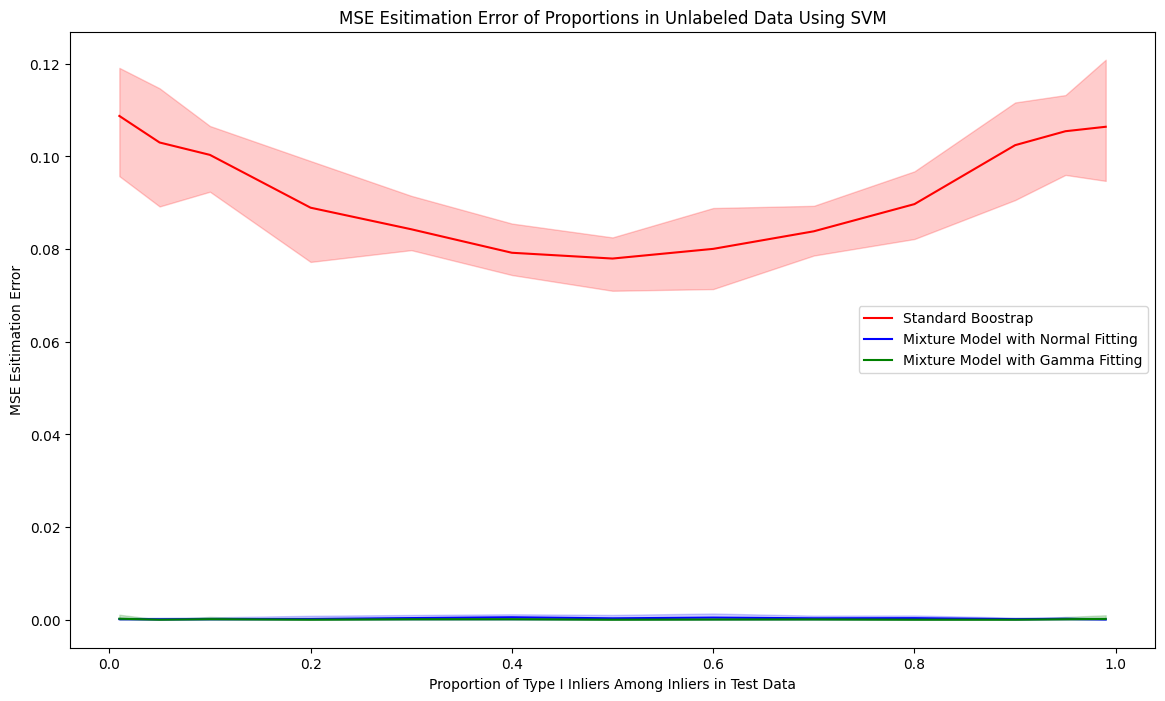

In [109]:
# Plotting
plt.figure(figsize=(14, 8))

plt.plot(rho_values, proportion_difference['standard_boostrap'], label='Standard Boostrap', color='r')
plt.fill_between(rho_values, [ci[0] for ci in ci_proportion_difference['standard_boostrap']], [ci[1] for ci in ci_proportion_difference['standard_boostrap']], color='r', alpha=0.2)

plt.plot(rho_values, proportion_difference['normal'], label='Mixture Model with Normal Fitting', color='b')
plt.fill_between(rho_values, [ci[0] for ci in ci_proportion_difference['normal']], [ci[1] for ci in ci_proportion_difference['normal']], color='b', alpha=0.2)

plt.plot(rho_values, proportion_difference['gamma'], label='Mixture Model with Gamma Fitting', color='g')
plt.fill_between(rho_values, [ci[0] for ci in ci_proportion_difference['gamma']], [ci[1] for ci in ci_proportion_difference['gamma']], color='g', alpha=0.2)

plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
plt.ylabel('MSE Esitimation Error')
plt.title('MSE Esitimation Error of Proportions in Unlabeled Data Using SVM')
plt.legend()
plt.show()